In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from EHydro_TreeUnet.trainers import TreeProjectorTrainer
from torchsparse.nn import functional as F

F.set_kmap_mode("hashmap_on_the_fly")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
TRAINING = True

DATASET_FOLDER = Path.home() / 'datasets/MixedDataset'
WEIGHTS_FILE = 'tree_projector_weights_x16_0.2.pth'
FEAT_KEYS = ['intensity']
IGNORE_CLASS = []
CHANNELS = [16, 32, 64, 128]
LATENT_DIM = 256
MAX_INSTANCES = 64
TRAIN_PCT = 0.8
VOXEL_SIZE = 0.2
DATA_AUGMENTATION_COEF = 8.0
SEMANTIC_LOSS_COEF = 1.0
OFFSET_LOSS_COEF = 1.0
INSTANCE_LOSS_COEF = 1.0
COSINE_LOSS_COEF = 0.0
BATCH_SIZE = 1

In [3]:
def smooth(arr: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return arr

    kernel = np.ones(window, dtype=float)

    if arr.ndim == 1:
        denom = np.convolve(np.ones_like(arr), kernel, mode="same")
        return np.convolve(arr, kernel, mode="same") / denom

    # 2-D: suavizar cada columna por separado
    smoothed = np.empty_like(arr, dtype=float)
    denom = np.convolve(np.ones(arr.shape[0]), kernel, mode="same")
    for c in range(arr.shape[1]):
        smoothed[:, c] = np.convolve(arr[:, c], kernel, mode="same") / denom
    return smoothed
        
def gen_charts(trainer, losses, stats, training: bool, window: int = 10, ignore_class = []):
    keys = stats[0].keys()
    stats = {k: np.array([d[k] for d in stats]) for k in keys}

    losses_s      = smooth(np.asarray(losses), window)
    miou_s        = smooth(stats['miou'], window)
    iou_s         = smooth(np.asarray(stats['iou_per_class']), window)
    prec_macro_s  = smooth(stats['precision_macro'], window)
    prec_s        = smooth(np.asarray(stats['precision_per_class']), window)
    recall_macro_s= smooth(stats['recall_macro'], window)
    recall_s      = smooth(np.asarray(stats['recall_per_class']), window)
    f1_macro_s    = smooth(stats['f1_macro'], window)
    f1_s          = smooth(np.asarray(stats['f1_per_class']), window)

    # --- 1. Loss -------------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(losses_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- 2. mIoU (macro) -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(miou_s, label=f"{'Training' if training else 'Inference'} mIoU (MA{window})")
    plt.xlabel("Step"); plt.ylabel("mIoU")
    plt.title(f"mIoU evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 3. IoU per class ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(iou_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("IoU")
    plt.title(f"IoU evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 4. Precision (macro) -----------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(prec_macro_s, label=f"{'Training' if training else 'Inference'} precision (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 5. Precision per class ---------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(prec_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 6. Recall (macro) ---------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(recall_macro_s, label=f"{'Training' if training else 'Inference'} recall (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 7. Recall per class -------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(recall_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 8. F1 (macro) -------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(f1_macro_s, label=f"{'Training' if training else 'Inference'} F1 (MA{window})")
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 9. F1 per class -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(f1_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    column_names = ['IoU', 'Precision', 'Recall', 'F1']
    row_names = [trainer.dataset.class_names[c] for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]
    row_names.append('Mean')

    iou_arr = np.asarray(stats['iou_per_class'])
    prec_arr = np.asarray(stats['precision_per_class'])
    recall_arr = np.asarray(stats['recall_per_class'])
    f1_arr = np.asarray(stats['f1_per_class'])

    data = [
        [iou_arr[:, c].mean(), prec_arr[:, c].mean(), recall_arr[:, c].mean(), f1_arr[:, c].mean()]
    for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]

    means = np.array(data).mean(axis=0)
    data.append(list(means))

    df = pd.DataFrame(data, columns=column_names, index=row_names)
    display(df)

tf32 enabled: False
Parámetros totales: 12,861,040
Parámetros entrenables: 12,861,040


[Train]:   0%|          | 0/584 [00:00<?, ?it/s]/home/samuel/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
[Train]: 100%|██████████| 584/584 [37:07<00:00,  3.81s/it, loss=9.3946, mIoU=0.7559]   


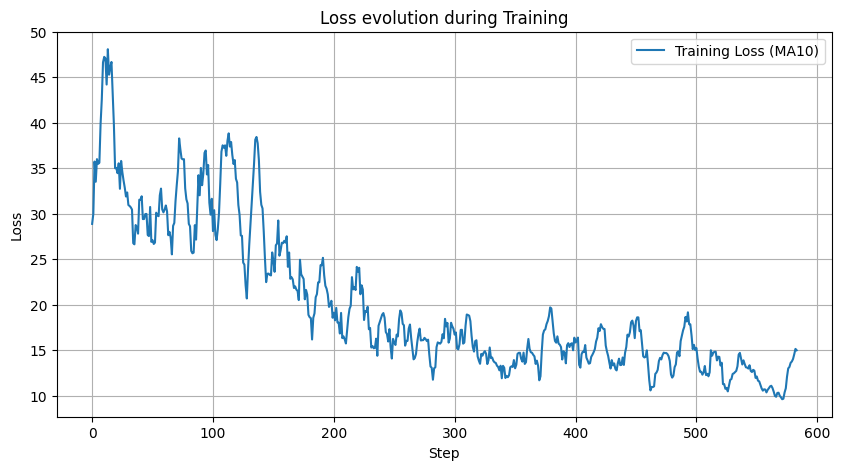

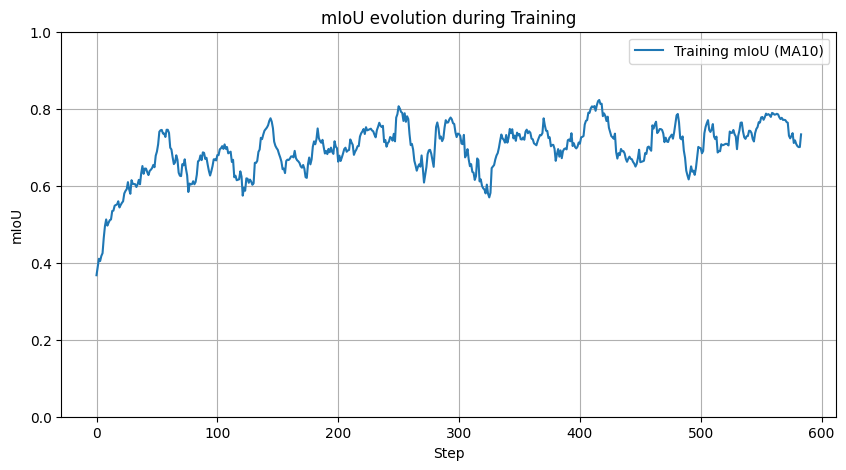

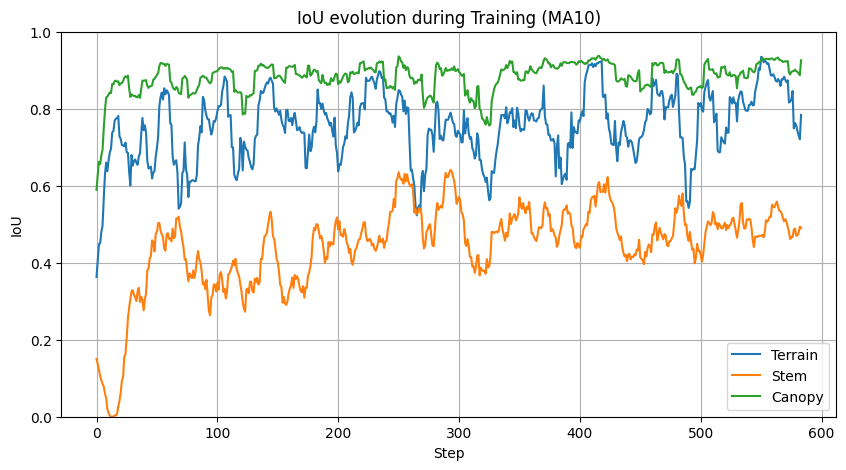

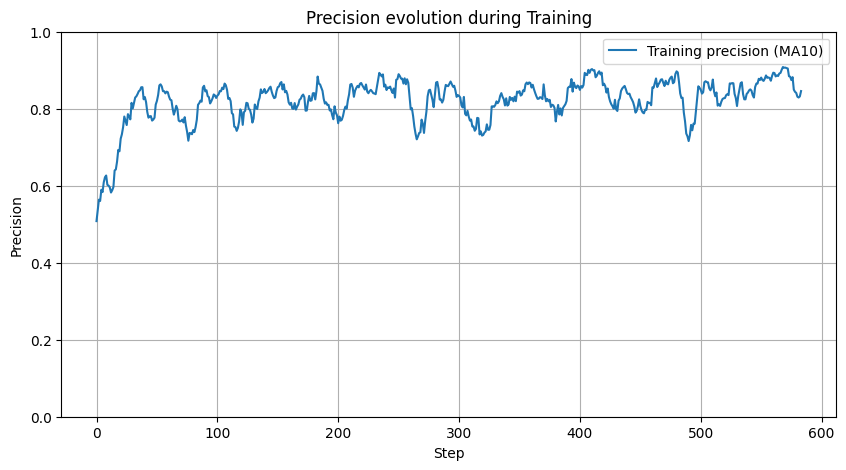

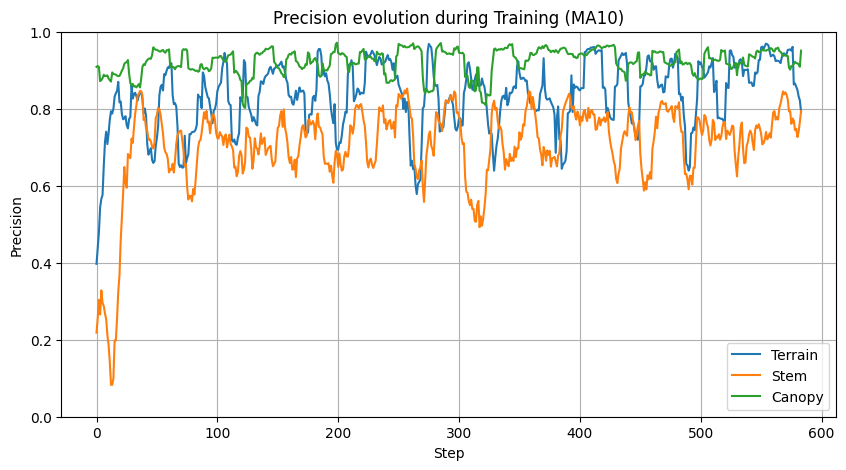

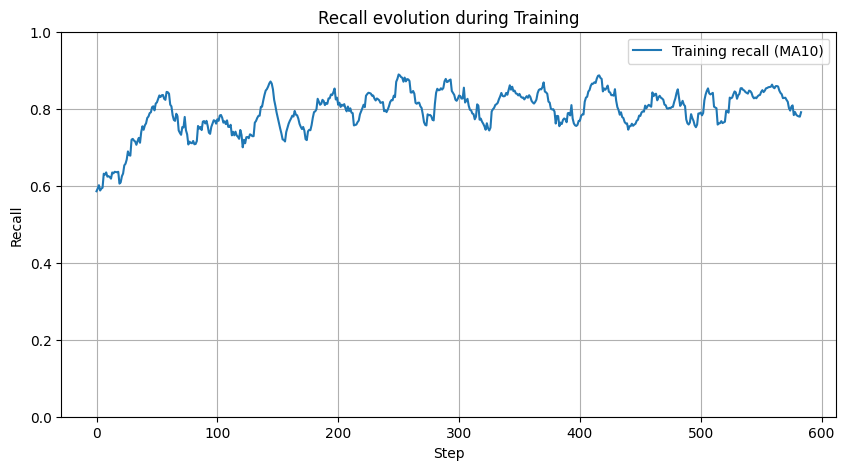

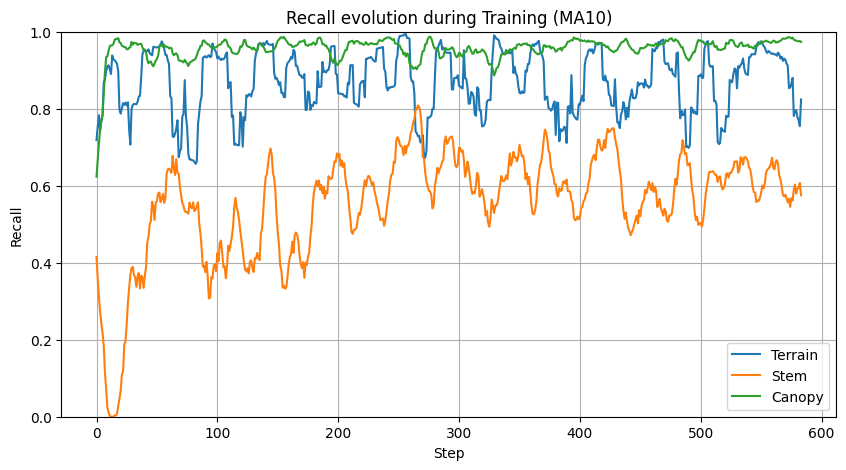

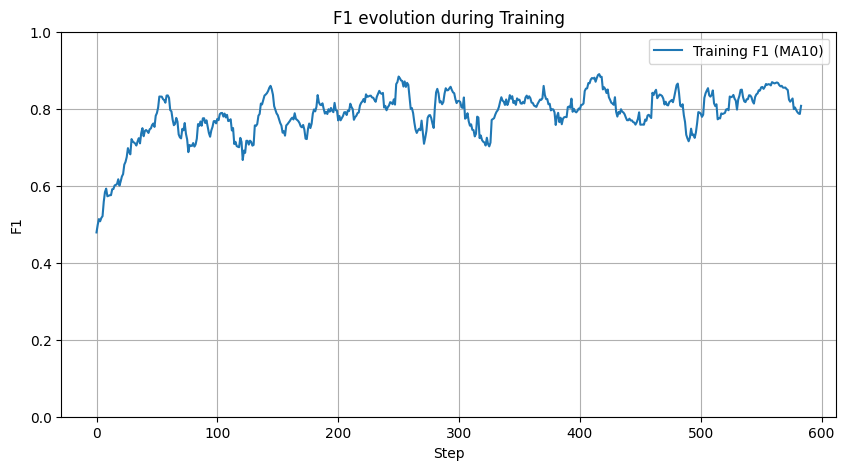

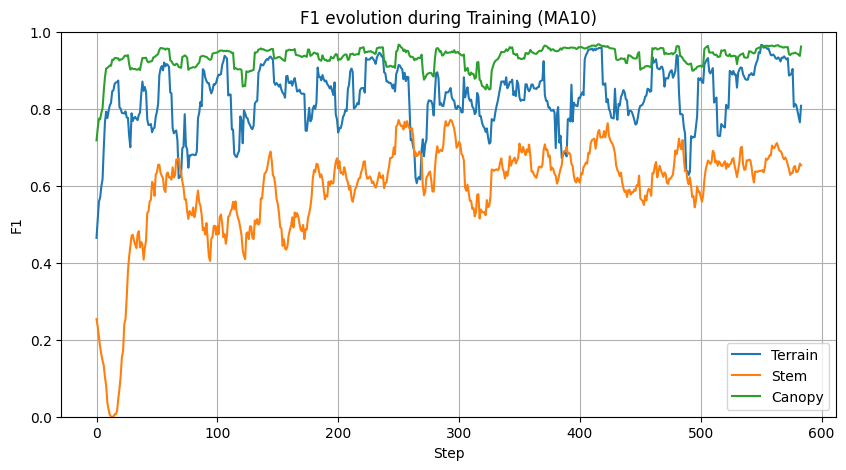

,IoU,Precision,Recall,F1
Terrain,0.753422,0.833639,0.868840,0.828942
Stem,0.444681,0.705884,0.555531,0.593287
Canopy,0.882405,0.922365,0.955814,0.933668
Mean,0.693503,0.820629,0.793395,0.785299


[Inference]: 100%|██████████| 19/19 [03:32<00:00, 11.16s/it, loss=5.3827, mIoU=0.6476] 


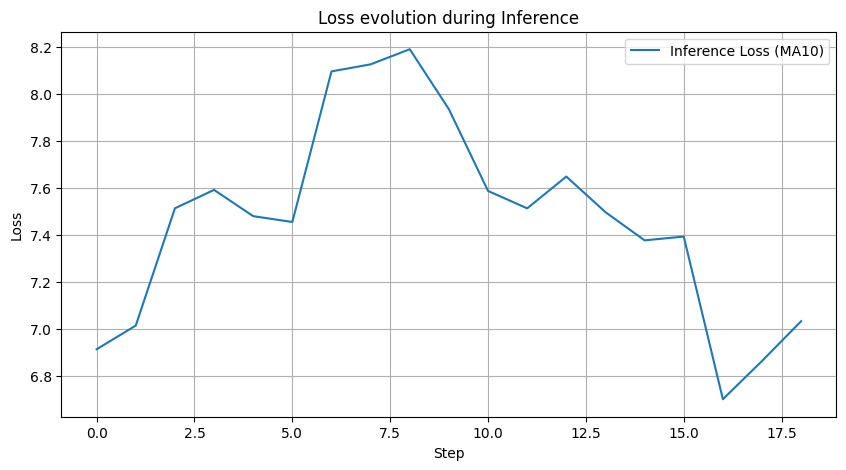

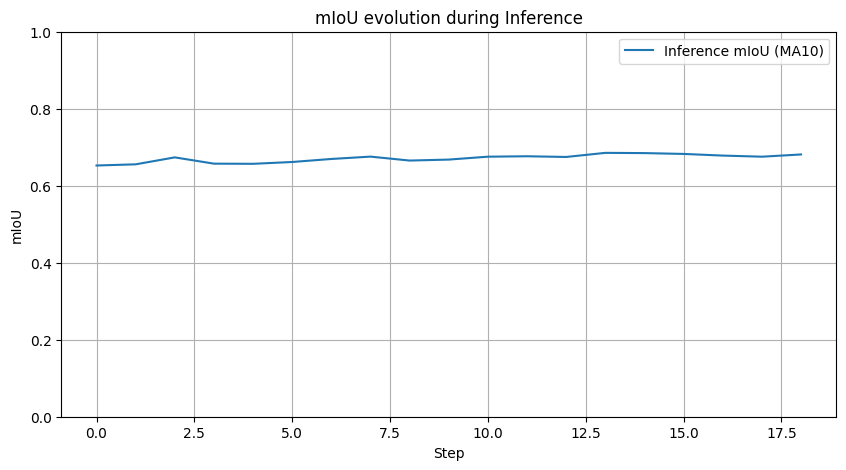

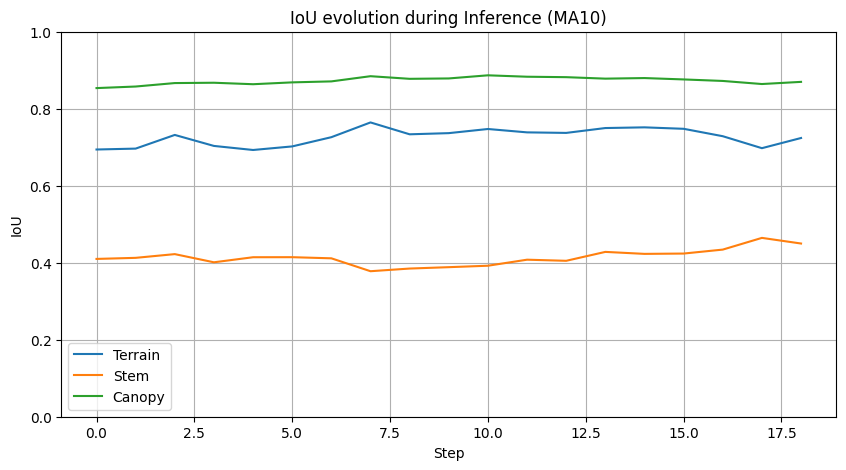

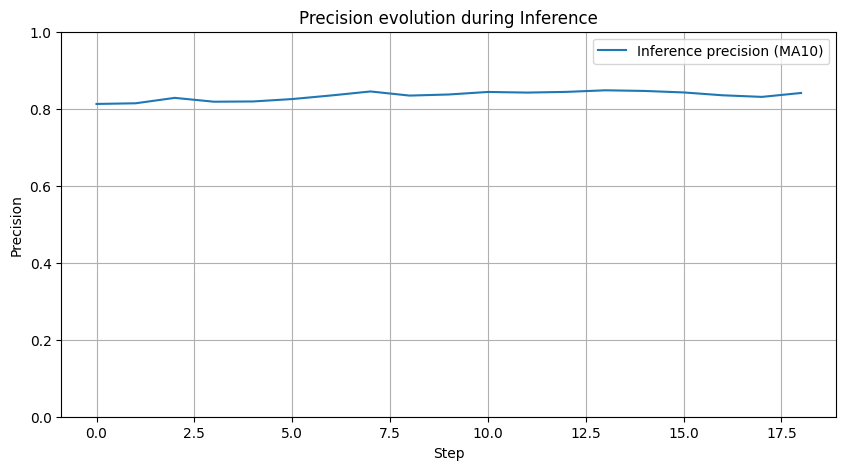

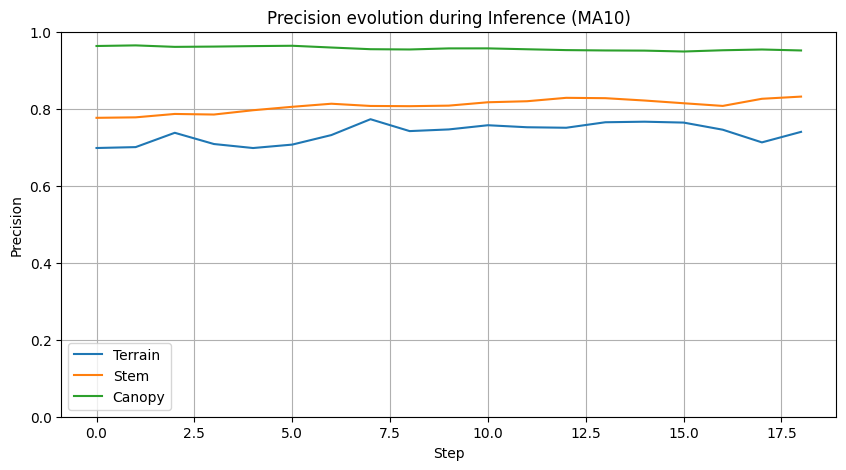

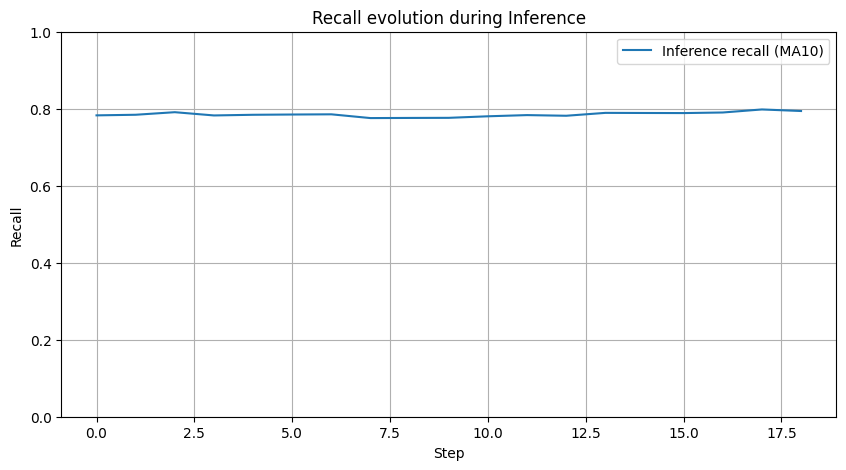

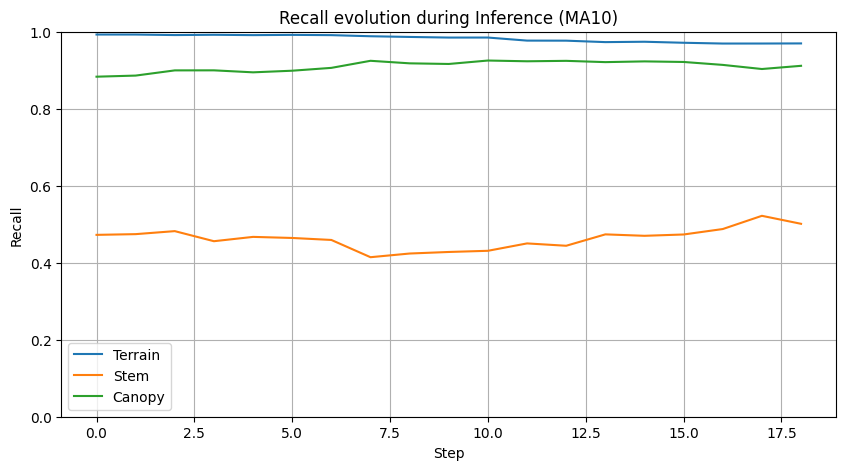

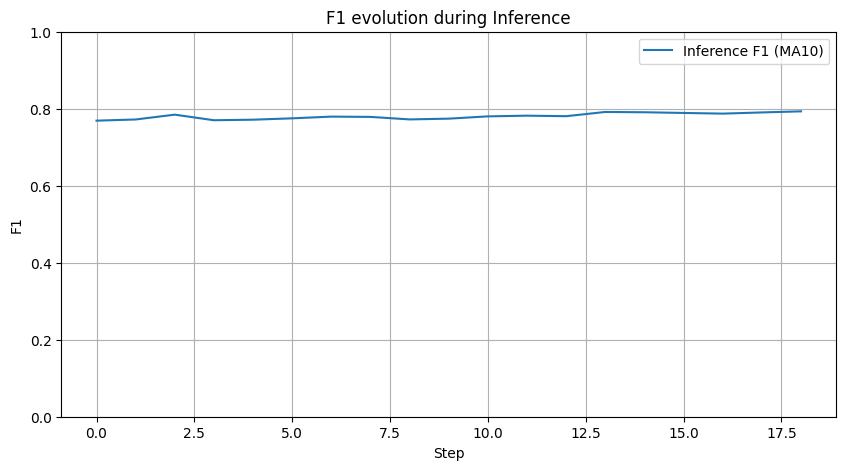

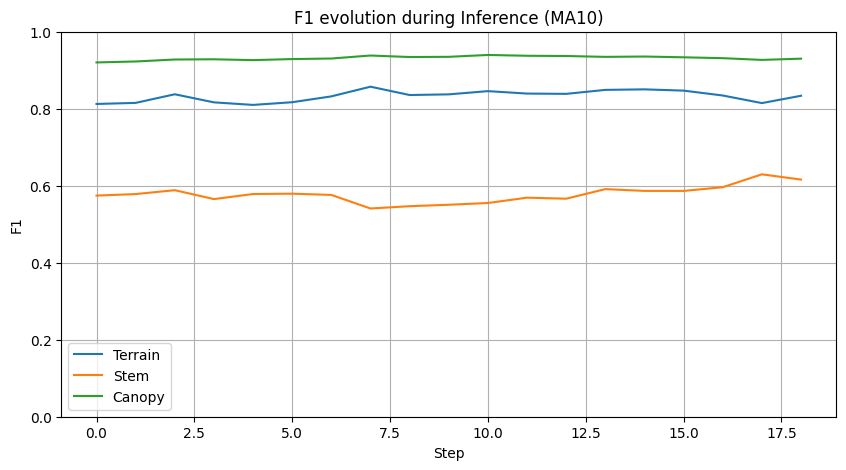

,IoU,Precision,Recall,F1
Terrain,0.723767,0.733896,0.982104,0.831160
Stem,0.418851,0.809359,0.468583,0.582715
Canopy,0.872062,0.956466,0.909482,0.931145
Mean,0.671560,0.833240,0.786723,0.781673


In [ ]:
tester = TreeProjectorTrainer(
    dataset_folder=DATASET_FOLDER,
    voxel_size=VOXEL_SIZE,
    train_pct=TRAIN_PCT,
    data_augmentation_coef=DATA_AUGMENTATION_COEF,
    feat_keys=FEAT_KEYS,
    max_instances=MAX_INSTANCES,
    channels=CHANNELS,
    latent_dim=LATENT_DIM,
    batch_size=BATCH_SIZE,
    training=TRAINING,
    semantic_loss_coef=SEMANTIC_LOSS_COEF,
    offset_loss_coef=OFFSET_LOSS_COEF,
    instance_loss_coef=INSTANCE_LOSS_COEF,
    cosine_loss_coef=COSINE_LOSS_COEF,
)

if TRAINING:
    tester.train()
    stats = tester.stats
    losses = tester.losses
    gen_charts(tester, losses, stats, True, ignore_class=IGNORE_CLASS)

pcd = o3d.geometry.PointCloud()
for voxels, semantic_output, offset_output, semantic_labels, offset_labels in tester.eval():
    batch_idx = voxels[:, 0]
    voxels = voxels[:, 1:]
    # coords = coords[0]
    # inverse_map = inverse_map[0]

    for idx in np.unique(batch_idx):
        mask = batch_idx == idx
        cloud_voxels = voxels[mask]
        cloud_semantic_labels = semantic_labels[mask]
        cloud_semantic_output = semantic_output[mask]
        cloud_offset_labels = offset_labels[mask]
        cloud_offset_output = offset_output[mask]

        pcd.points = o3d.utility.Vector3dVector(cloud_voxels)

        # colors = tester.dataset.class_colormap[semantic_labels[inverse_map]] / 255.0
        colors = tester.dataset.class_colormap[cloud_semantic_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        # colors = tester.dataset.class_colormap[semantic_output[inverse_map]] / 255.0
        colors = tester.dataset.class_colormap[cloud_semantic_output] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        pcd.points = o3d.utility.Vector3dVector(voxels + offset_labels)
        o3d.visualization.draw_geometries([pcd])

        pcd.points = o3d.utility.Vector3dVector(voxels + offset_output)
        o3d.visualization.draw_geometries([pcd])

        '''
        unique_ids = np.unique(cloud_instance_labels)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_labels], dtype=np.float64)

        # pcd.colors = o3d.utility.Vector3dVector(colors[inverse_map])
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        unique_ids = np.unique(cloud_instance_output)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_output], dtype=np.float64)

        # pcd.colors = o3d.utility.Vector3dVector(colors[inverse_map])
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])
        '''

stats = tester.stats
losses = tester.losses
gen_charts(tester, losses, stats, False, ignore_class=IGNORE_CLASS)
